In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import *
%matplotlib inline

In [2]:
spark = SparkSession.builder.master("local").appName('Ops').getOrCreate()

In [3]:
#path = "E:/Rutgers/Projects/MDSR/IPL-MSDR"
path = '/Users/nidhiharwani/Desktop/Most_Valuable_Player_Prediction_using_IPL_Dataset'

In [4]:
# Reading Data
matches = pd.read_csv(path + '/dataset/clean_data/matches.csv')
deliveries = pd.read_csv(path + '/dataset/clean_data/deliveries.csv')

In [5]:
# Schema of original data (matches.csv)
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 15 columns):
Unnamed: 0         756 non-null int64
id                 756 non-null int64
season             756 non-null int64
city               756 non-null object
team1              756 non-null object
team2              756 non-null object
toss_winner        756 non-null object
toss_decision      756 non-null object
result             756 non-null object
dl_applied         756 non-null int64
winner             756 non-null object
win_by_runs        756 non-null int64
win_by_wickets     756 non-null int64
player_of_match    752 non-null object
venue              756 non-null object
dtypes: int64(6), object(9)
memory usage: 88.7+ KB


In [6]:
# Schema of original data (deliveries.csv)
deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179078 entries, 0 to 179077
Data columns (total 22 columns):
Unnamed: 0          179078 non-null int64
match_id            179078 non-null int64
inning              179078 non-null int64
batting_team        179078 non-null object
bowling_team        179078 non-null object
over                179078 non-null int64
ball                179078 non-null int64
batsman             179078 non-null object
non_striker         179078 non-null object
bowler              179078 non-null object
is_super_over       179078 non-null int64
wide_runs           179078 non-null int64
bye_runs            179078 non-null int64
legbye_runs         179078 non-null int64
noball_runs         179078 non-null int64
penalty_runs        179078 non-null int64
batsman_runs        179078 non-null int64
extra_runs          179078 non-null int64
total_runs          179078 non-null int64
player_dismissed    179078 non-null object
dismissal_kind      179078 non-null object


# Basic Analysis

In [7]:
# Teams playing in the league
teams = matches['team1'].unique()
print("Total number of teams participated so far: " + str(len(matches['team1'].unique())))
print("Teams participated so far: ")
for i in teams:
    print("- " + i)

Total number of teams participated so far: 14
Teams participated so far: 
- Sunrisers Hyderabad
- Mumbai Indians
- Gujarat Lions
- Rising Pune Supergiant
- Royal Challengers Bangalore
- Kolkata Knight Riders
- Delhi Daredevils
- Kings XI Punjab
- Chennai Super Kings
- Rajasthan Royals
- Deccan Chargers
- Kochi Tuskers Kerala
- Pune Warriors
- Delhi Capitals


In [8]:
# Total Venues
print("Number of venues matches were played: " + str(len(matches['venue'].unique())))
for i in matches['venue'].unique():
    print("- " + i)

Number of venues matches were played: 41
- Rajiv Gandhi International Stadium, Uppal
- Maharashtra Cricket Association Stadium
- Saurashtra Cricket Association Stadium
- Holkar Cricket Stadium
- M Chinnaswamy Stadium
- Wankhede Stadium
- Eden Gardens
- Feroz Shah Kotla
- Punjab Cricket Association IS Bindra Stadium, Mohali
- Green Park
- Punjab Cricket Association Stadium, Mohali
- Sawai Mansingh Stadium
- MA Chidambaram Stadium, Chepauk
- Dr DY Patil Sports Academy
- Newlands
- St George's Park
- Kingsmead
- SuperSport Park
- Buffalo Park
- New Wanderers Stadium
- De Beers Diamond Oval
- OUTsurance Oval
- Brabourne Stadium
- Sardar Patel Stadium, Motera
- Barabati Stadium
- Vidarbha Cricket Association Stadium, Jamtha
- Himachal Pradesh Cricket Association Stadium
- Nehru Stadium
- Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium
- Subrata Roy Sahara Stadium
- Shaheed Veer Narayan Singh International Stadium
- JSCA International Stadium Complex
- Sheikh Zayed Stadium
- Sharjah Cric

In [9]:
# Cities the matches were played
print("Number of cities matches were played: " + str(len(matches['city'].unique())))
for i in matches['city'].unique():
    print("- " + str(i))

Number of cities matches were played: 33
- Hyderabad
- Pune
- Rajkot
- Indore
- Bangalore
- Mumbai
- Kolkata
- Delhi
- Chandigarh
- Kanpur
- Jaipur
- Chennai
- Cape Town
- Port Elizabeth
- Durban
- Centurion
- East London
- Johannesburg
- Kimberley
- Bloemfontein
- Ahmedabad
- Cuttack
- Nagpur
- Dharamsala
- Kochi
- Visakhapatnam
- Raipur
- Ranchi
- Abu Dhabi
- Sharjah
- Dubai
- Mohali
- Bengaluru


In [10]:
# Total number of bowlers so far
print("Total number of bowlers: " + str(len(deliveries['bowler'].unique())))

Total number of bowlers: 405


In [11]:
# Total number of batsmen so far
print("Total number of batsmen: " + str(len(deliveries['batsman'].unique())))

Total number of batsmen: 516


In [12]:
# Total number of participating players
players = set()
for i in range(len(deliveries['match_id'])):
    players.add(deliveries['bowler'][i])
    players.add(deliveries['batsman'][i])
    players.add(deliveries['non_striker'][i])
print("Total number of player: " + str(len(players)))

Total number of player: 559


# Spark Analysis

In [13]:
# Reading Data
matches = spark.read.csv(path + '/dataset/clean_data/matches.csv',inferSchema=True,header=True)
deliveries = spark.read.csv(path + '/dataset/clean_data/deliveries.csv',inferSchema=True,header=True)

### Total number of matches per season

In [14]:
matches.registerTempTable('seasons')
seasons = spark.sql('''Select distinct(season),count(*) as total_matches from seasons group by season ''') 
seasons.show()

+------+-------------+
|season|total_matches|
+------+-------------+
|  2018|           60|
|  2015|           59|
|  2013|           76|
|  2014|           60|
|  2019|           60|
|  2012|           74|
|  2009|           57|
|  2016|           60|
|  2010|           60|
|  2011|           73|
|  2008|           58|
|  2017|           59|
+------+-------------+



Text(0.5,1,'Number of matches in each season')

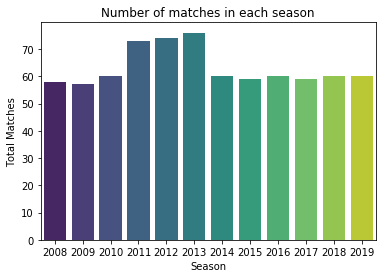

In [15]:
# Plot
fig, a = plt.subplots()
a = sns.barplot(x ="season", y="total_matches", data=seasons.toPandas(),palette='viridis')
a.set_xlabel('Season')
a.set_ylabel('Total Matches')
a.set_title('Number of matches in each season')

### Number of maches played by each team since season 1

In [16]:
matches.registerTempTable('team')
team = spark.sql('''Select distinct(team), count(*) as total_matches \
                    from (Select team1 as team from team UNION ALL (select team2 as team from team)) group by team ''')
team.show()

+--------------------+-------------+
|                team|total_matches|
+--------------------+-------------+
| Sunrisers Hyderabad|          108|
| Chennai Super Kings|          164|
|Rising Pune Super...|           30|
|     Deccan Chargers|           75|
|Kochi Tuskers Kerala|           14|
|    Rajasthan Royals|          147|
|       Gujarat Lions|           30|
|Royal Challengers...|          180|
|Kolkata Knight Ri...|          178|
|     Kings XI Punjab|          176|
|       Pune Warriors|           46|
|    Delhi Daredevils|          161|
|      Delhi Capitals|           16|
|      Mumbai Indians|          187|
+--------------------+-------------+



Text(0.5,1,'Number of matches played by each team')

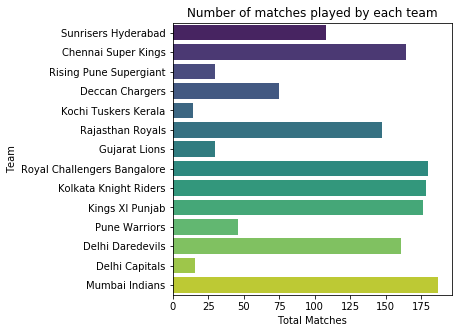

In [17]:
# Plot
fig, a = plt.subplots(figsize = (5,5))
a = sns.barplot(x ="total_matches", y="team", data=team.toPandas(), palette='viridis')
a.set_ylabel('Team')
a.set_xlabel('Total Matches')
a.set_title('Number of matches played by each team')

### Total season in which teams have played

In [18]:
matches.registerTempTable('team_season')
team_season = spark.sql('''Select team1 as team, min(season) as first_season, max(season) as last_season, count(distinct(season)) as total_seasons from team_season group by team1 order by total_seasons desc''')
team_season.show()

+--------------------+------------+-----------+-------------+
|                team|first_season|last_season|total_seasons|
+--------------------+------------+-----------+-------------+
|Royal Challengers...|        2008|       2019|           12|
|Kolkata Knight Ri...|        2008|       2019|           12|
|     Kings XI Punjab|        2008|       2019|           12|
|      Mumbai Indians|        2008|       2019|           12|
|    Delhi Daredevils|        2008|       2018|           11|
| Chennai Super Kings|        2008|       2019|           10|
|    Rajasthan Royals|        2008|       2019|           10|
| Sunrisers Hyderabad|        2013|       2019|            7|
|     Deccan Chargers|        2008|       2012|            5|
|       Pune Warriors|        2011|       2013|            3|
|Rising Pune Super...|        2016|       2017|            2|
|       Gujarat Lions|        2016|       2017|            2|
|Kochi Tuskers Kerala|        2011|       2011|            1|
|      D

### Total number of matches won by teams

In [19]:
matches.registerTempTable('most_win')
most_win = spark.sql('''Select distinct(winner) as team, count(*) as total_matches from most_win where winner <> 'None' group by winner order by total_matches ''')
most_win.show()

+--------------------+-------------+
|                team|total_matches|
+--------------------+-------------+
|                Draw|            4|
|Kochi Tuskers Kerala|            6|
|      Delhi Capitals|           10|
|       Pune Warriors|           12|
|       Gujarat Lions|           13|
|Rising Pune Super...|           15|
|     Deccan Chargers|           29|
| Sunrisers Hyderabad|           58|
|    Delhi Daredevils|           67|
|    Rajasthan Royals|           75|
|     Kings XI Punjab|           82|
|Royal Challengers...|           84|
|Kolkata Knight Ri...|           92|
| Chennai Super Kings|          100|
|      Mumbai Indians|          109|
+--------------------+-------------+



Text(0.5,1,'Number of matches won by each team')

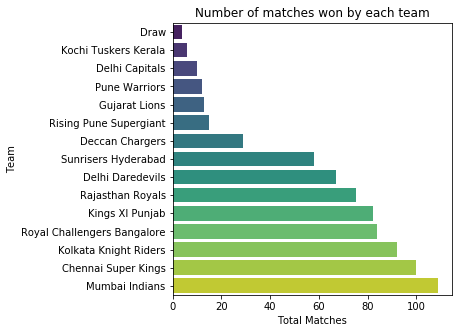

In [20]:
# Plot
fig, a = plt.subplots(figsize = (5,5))
a = sns.barplot(x ="total_matches", y="team", data=most_win.toPandas(), palette='viridis')
a.set_ylabel('Team')
a.set_xlabel('Total Matches')
a.set_title('Number of matches won by each team')

### Total matches won by teams in each season

In [21]:
matches.registerTempTable('most_win_by_season')
most_win_by_season = spark.sql('''Select season, winner as team, count(*) as total_matches_won from most_win_by_season where winner <> 'None' group by season, winner order by total_matches_won desc''')
most_win_by_season.show()

+------+--------------------+-----------------+
|season|                team|total_matches_won|
+------+--------------------+-----------------+
|  2013|      Mumbai Indians|               13|
|  2008|    Rajasthan Royals|               13|
|  2017|      Mumbai Indians|               12|
|  2012|Kolkata Knight Ri...|               12|
|  2013| Chennai Super Kings|               12|
|  2014|     Kings XI Punjab|               12|
|  2016| Sunrisers Hyderabad|               11|
|  2011| Chennai Super Kings|               11|
|  2018| Chennai Super Kings|               11|
|  2013|    Rajasthan Royals|               11|
|  2010|      Mumbai Indians|               11|
|  2014|Kolkata Knight Ri...|               11|
|  2012|    Delhi Daredevils|               11|
|  2019|      Mumbai Indians|               11|
|  2014| Chennai Super Kings|               10|
|  2012| Chennai Super Kings|               10|
|  2009|    Delhi Daredevils|               10|
|  2017|Rising Pune Super...|           

### Players with maximum man of the match awards 

In [22]:
matches.registerTempTable('man_match')
man_match = spark.sql('''Select distinct(player_of_match), count(*) as total_matches from man_match group by player_of_match order by total_matches desc limit 10 ''')
man_match.show()

+---------------+-------------+
|player_of_match|total_matches|
+---------------+-------------+
|       CH Gayle|           21|
| AB de Villiers|           20|
|      RG Sharma|           17|
|      DA Warner|           17|
|       MS Dhoni|           17|
|      YK Pathan|           16|
|      SR Watson|           15|
|       SK Raina|           14|
|      G Gambhir|           13|
|      AM Rahane|           12|
+---------------+-------------+



Text(0.5,1,'Number of times player won man of the match')

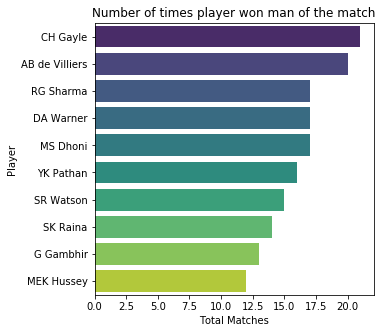

In [23]:
# Plot
fig, a = plt.subplots(figsize = (5,5))
a = sns.barplot(x ="total_matches", y="player_of_match", data=man_match.toPandas(), palette='viridis')
a.set_xlabel('Total Matches')
a.set_ylabel('Player')
a.set_title('Number of times player won man of the match')

### Number of matches per Venue

In [24]:
matches.registerTempTable('venue')
venue = spark.sql('''Select distinct(venue), count(*) as total_matches from venue group by venue''')
venue.show()

+--------------------+-------------+
|               venue|total_matches|
+--------------------+-------------+
|Dubai Internation...|            7|
|Himachal Pradesh ...|            9|
|Sardar Patel Stad...|           12|
|Punjab Cricket As...|           35|
|    Barabati Stadium|            7|
|Punjab Cricket As...|           14|
|       Nehru Stadium|            5|
|Maharashtra Crick...|           21|
|        Eden Gardens|           77|
|     OUTsurance Oval|            2|
|M Chinnaswamy Sta...|           73|
|    Feroz Shah Kotla|           67|
|M. A. Chidambaram...|            8|
|Rajiv Gandhi Inte...|           56|
|   Brabourne Stadium|           11|
|Vidarbha Cricket ...|            3|
|          Green Park|            4|
|Holkar Cricket St...|            9|
|Feroz Shah Kotla ...|            7|
|Shaheed Veer Nara...|            6|
+--------------------+-------------+
only showing top 20 rows



Text(0.5,1,'Number of matches at each venue')

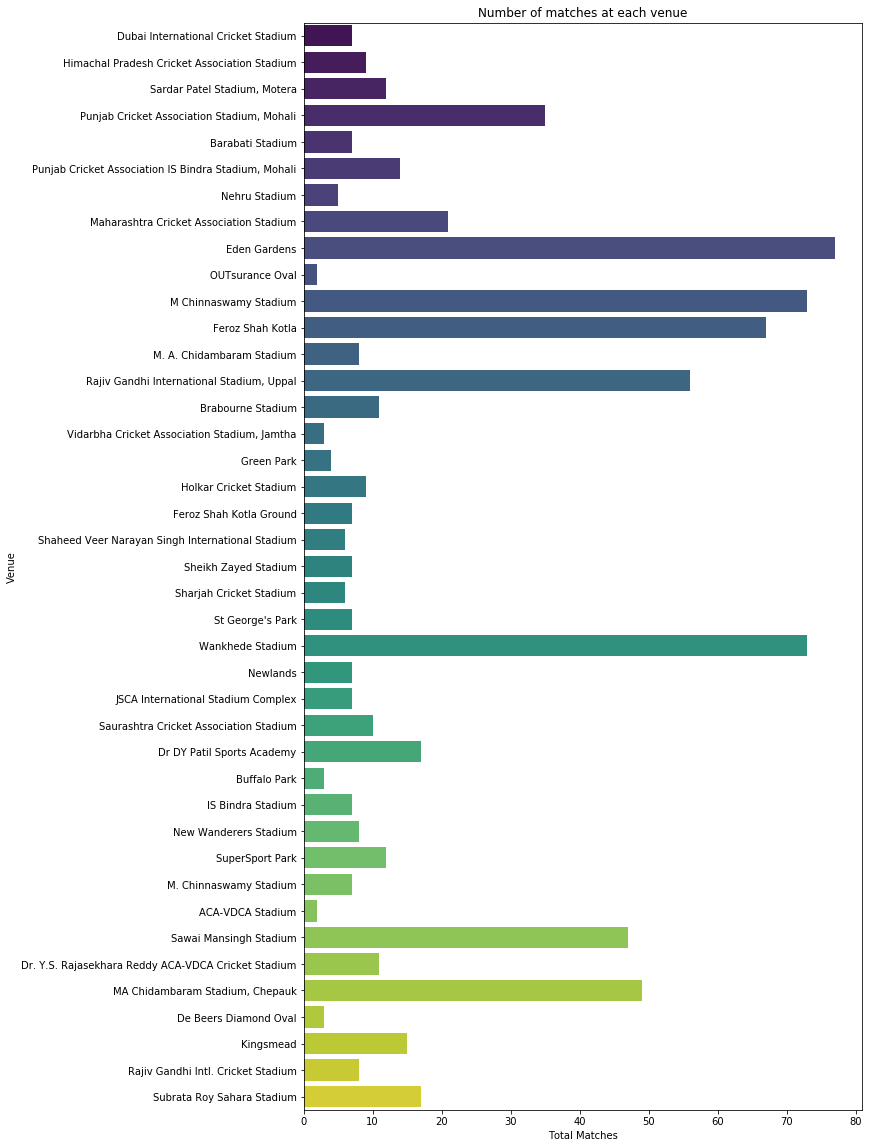

In [25]:
# Plot
fig, a = plt.subplots(figsize = (10,20))
a = sns.barplot(x ="total_matches", y="venue", data=venue.toPandas(), palette='viridis')
a.set_ylabel('Venue')
a.set_xlabel('Total Matches')
a.set_title('Number of matches at each venue')

### Percentage toss decisions 

In [26]:
matches.registerTempTable('toss')
toss = spark.sql('Select distinct(toss_decision), round(((count(toss_decision)*100)/(select count(*) from toss)),5) as percentage_count \
                  from toss group by toss_decision')
toss.show()

+-------------+----------------+
|toss_decision|percentage_count|
+-------------+----------------+
|        field|        61.24339|
|          bat|        38.75661|
+-------------+----------------+



Text(0.5,1,'Percentage Plot of toss_decision')

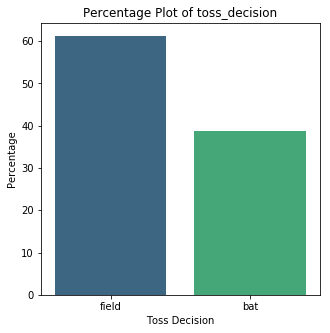

In [27]:
# Plot
fig, a = plt.subplots(figsize = (5,5))
a = sns.barplot(x ="toss_decision", y="percentage_count", data=toss.toPandas(), palette='viridis')
a.set_ylabel('Percentage')
a.set_xlabel('Toss Decision')
a.set_title('Percentage Plot of toss_decision')

### Percentage of team winning the toss as well as the match

In [28]:
matches.registerTempTable('toss_and_won')
matches.registerTempTable('toss_won_data')
toss_won_data = spark.sql('''Select t1.season, t1.total_matches, \
          t2.count_toss_and_won as count_toss_and_won, \
          round((t2.count_toss_and_won / t1.total_matches * 100),5) as percent_toss_and_won from \
          (Select distinct(season),count(*) as total_matches from seasons group by season)t1 \
          left join (Select distinct(season), count(*) as count_toss_and_won from toss_and_won where toss_winner = winner group by season)t2 on t1.season = t2.season order by season''')
toss_won_data.show()

+------+-------------+------------------+--------------------+
|season|total_matches|count_toss_and_won|percent_toss_and_won|
+------+-------------+------------------+--------------------+
|  2008|           58|                28|            48.27586|
|  2009|           57|                33|            57.89474|
|  2010|           60|                31|            51.66667|
|  2011|           73|                38|            52.05479|
|  2012|           74|                33|            44.59459|
|  2013|           76|                36|            47.36842|
|  2014|           60|                30|                50.0|
|  2015|           59|                28|            47.45763|
|  2016|           60|                34|            56.66667|
|  2017|           59|                34|            57.62712|
|  2018|           60|                32|            53.33333|
|  2019|           60|                36|                60.0|
+------+-------------+------------------+--------------

Text(0.5,1,'Percentage Plot of Season and Toss_and_won')

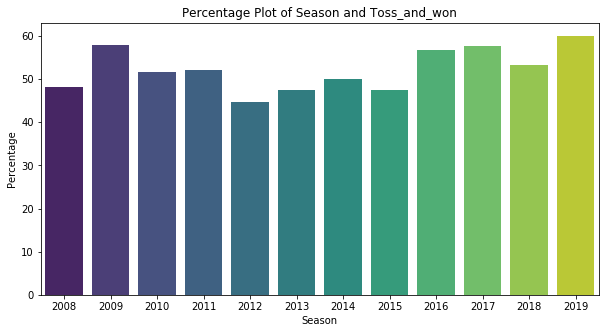

In [29]:
# Plot
fig, a = plt.subplots(figsize = (10,5))
a = sns.barplot(x ="season", y="percent_toss_and_won", data=toss_won_data.toPandas(), palette='viridis')
a.set_ylabel('Percentage')
a.set_xlabel('Season')
a.set_title('Percentage Plot of Season and Toss_and_won')

### Percentage matches won by batting first 

In [30]:
win_batting_first = spark.sql('''Select t1.season, t1.total_matches, \
          t2.win_batting_first as win_batting_first, \
          round((t2.win_batting_first/ t1.total_matches * 100),5) as percent_win_batting_first from \
          (Select distinct(season),count(*) as total_matches from seasons group by season)t1 \
          left join (Select distinct(season), count(*) as win_batting_first from seasons where win_by_runs > 0  group by season)t2 on t1.season = t2.season order by season ''')
win_batting_first.show()

+------+-------------+-----------------+-------------------------+
|season|total_matches|win_batting_first|percent_win_batting_first|
+------+-------------+-----------------+-------------------------+
|  2008|           58|               24|                 41.37931|
|  2009|           57|               27|                 47.36842|
|  2010|           60|               31|                 51.66667|
|  2011|           73|               33|                 45.20548|
|  2012|           74|               34|                 45.94595|
|  2013|           76|               37|                 48.68421|
|  2014|           60|               22|                 36.66667|
|  2015|           59|               32|                 54.23729|
|  2016|           60|               21|                     35.0|
|  2017|           59|               26|                  44.0678|
|  2018|           60|               28|                 46.66667|
|  2019|           60|               22|                 36.66

Text(0.5,1,'Percentage Plot of Season and won by batting')

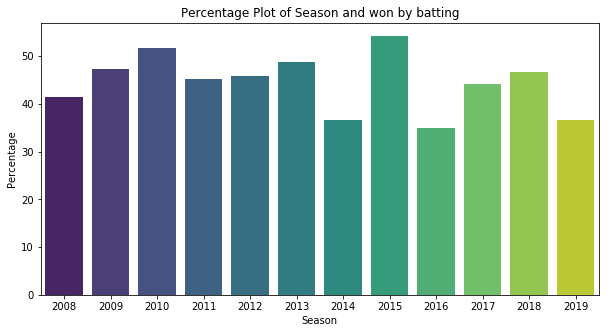

In [31]:
# Plot
fig, a = plt.subplots(figsize = (10,5))
a = sns.barplot(x ="season", y="percent_win_batting_first", data=win_batting_first.toPandas(), palette='viridis')
a.set_ylabel('Percentage')
a.set_xlabel('Season')
a.set_title('Percentage Plot of Season and won by batting')

### Percentage matches won by fielding first

In [32]:
win_bowling_first = spark.sql('''Select t1.season, t1.total_matches, \
          t2.win_bowling_first as win_bowling_first, \
          round((t2.win_bowling_first/ t1.total_matches * 100),5) as percent_win_bowling_first from \
          (Select distinct(season),count(*) as total_matches from seasons group by season)t1 \
          left join (Select distinct(season), count(*) as win_bowling_first from seasons where win_by_wickets > 0  group by season)t2 on t1.season = t2.season order by season ''')
win_bowling_first.show()

+------+-------------+-----------------+-------------------------+
|season|total_matches|win_bowling_first|percent_win_bowling_first|
+------+-------------+-----------------+-------------------------+
|  2008|           58|               34|                 58.62069|
|  2009|           57|               29|                 50.87719|
|  2010|           60|               28|                 46.66667|
|  2011|           73|               39|                 53.42466|
|  2012|           74|               40|                 54.05405|
|  2013|           76|               37|                 48.68421|
|  2014|           60|               37|                 61.66667|
|  2015|           59|               24|                 40.67797|
|  2016|           60|               39|                     65.0|
|  2017|           59|               32|                 54.23729|
|  2018|           60|               32|                 53.33333|
|  2019|           60|               35|                 58.33

Text(0.5,1,'Percentage Plot of Season and won by wickets ')

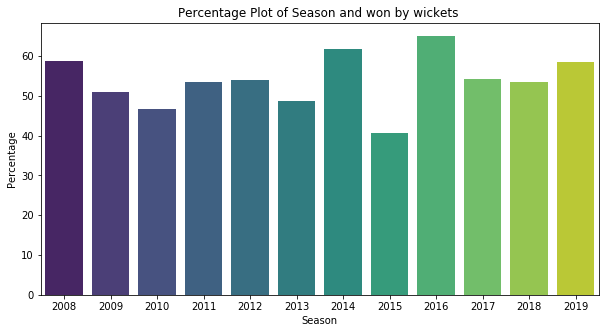

In [33]:
# Plot
fig, a = plt.subplots(figsize = (10,5))
a = sns.barplot(x ="season", y="percent_win_bowling_first", data=win_bowling_first.toPandas(), palette='viridis')
a.set_ylabel('Percentage')
a.set_xlabel('Season')
a.set_title('Percentage Plot of Season and won by wickets ')